In [2]:
# NOTE -> CODE WAS EXECUTED ON GOOGLE COLLAB, PLEASE UPDATE DIRECTORIES ACCORDINGLY
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# ---- LIBRARY IMPORTS ----
import torchtext
torchtext.disable_torchtext_deprecation_warning()
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time
from datetime import timedelta
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)
import math

# Setting seed for reproducibility
torch.manual_seed(0)
# ---- DEVICE SET UP ----
def get_gpu():
    if torch.backends.mps.is_available():
        print("Using mps")
        return "mps"
    elif torch.cuda.is_available():
        print("Using cuda")
        return"cuda"
    else:
        print("Using CPU")
        return "cpu"
device = get_gpu()

Using cuda


# Cleaning Data

In [ ]:
# # ---- DATA IMPORT ----
# # Specify data types for each column
# dtypes = {0: "UInt64", 1: "string", 2: "string", "3": "UInt64"}
# # Import data
# data_raw = pd.read_csv('data/fake_news/news_data.csv', dtype=dtypes)
# # Remove NA values
# data_no_na = data_raw.dropna()
# # Drop columns
# data_drop_columns = data_no_na.drop(columns=['Unnamed: 0', 'title'])
# # Drop duplicate rows
# clean_data = data_drop_columns.drop_duplicates()

In [14]:
# ---- READ IN NEW DATA ----
dypes = {'text': "string", 'label': 'Int64'}
clean_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/git/data/news_data.csv", dtype=dypes)
# clean_data = clean_data.sample(n=24000, random_state=0)
# # Drop columns
clean_data = clean_data.drop(columns=['Unnamed: 0', 'title'])

text     string[python]
label             Int64
dtype: object

In [17]:
"""
---- CLEANING TEXT DATA ----
The following steps will be taken to clean data
- all non-alphabetical data will be removed
- all emails and web urls will be removed
- all stop words will be removed based on the stop words in the ntlk dictionary
- all text will be made lowercase
"""

# Drop NA values if any
clean_data = clean_data.dropna()

# Regex function to clean strings
def regex_cleaner(text):
    try:
    # remove any web urls
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove email addresses
        text = re.sub(r'\b\w+@\w+\.\w+\b', '', text)
    # Make all text lowercase
        text_lowercase = text.lower()
    # Remove all non-alphanumeric text
        text_alphanumeric = re.sub(r'[^a-z\s\-]', '', text_lowercase)
    # Combine words that overlap to a new line
        no_overlap = re.sub(r'(\-\n)', '', text_alphanumeric)
    # remove \n and "-"
        no_new_line = re.sub(r'[\n\-]', ' ', no_overlap)
    # Remove extra spacing
        clean_text = re.sub(r'\s+', r' ', no_new_line)
        return clean_text
    except:
        raise Exception("Something went wrong :(")

# Clean text data!
clean_data['text'] = clean_data['text'].apply(regex_cleaner)
# clean_data['text'] = clean_data['text'].apply(lambda x: pos_lemmatize(str(x)))


# # Drop duplicate rows
clean_data = clean_data.drop_duplicates()


# Drop NA values if any afer cleaning
clean_data = clean_data.dropna()

# Write to csv to avoid wait time with tokenization
# clean_data.to_csv('data/fake_news/clean_news_data.csv', index=False)

In [18]:
# split data into train, test sets
train, test = train_test_split(clean_data, test_size=0.2, random_state=0)

# Create an iterator object for train and test data
data_iter = clean_data.iterrows()
train_iter = train.iterrows()
test_iter = test.iterrows()

# Convert generators to list of tuples because DataLoader does not work well with pandas dataframes
# Use this as inputs for DataLoader
data_list_of_tuples = [(row.text, row.label) for index, row in data_iter]
train_list_of_tuples = [(row.text, row.label) for index, row in train_iter]
test_list_of_tuples = [(row.text, row.label) for index, row in test_iter]

"""
Tokenization for word sequences
"""
def yield_tokens(data):
    """
    Pull the text data from series to tokenize it
    Each row is a series when calling the iterrows() method, you must call the text column to pull its value
    """
    tokenizer = get_tokenizer("basic_english")
    for index, row in data.iterrows():
        text = row.text
        yield tokenizer(text)

"""
vocab_dict is now a function that takes a list of words as an input and returns integers based on the indexes found in the vocab_dict's dictionary
<unk> -> In case a word is not in vocab_dict, we default it to a special index for words not in vocab_dict
"""
vocab_dict = build_vocab_from_iterator(iterator=yield_tokens(clean_data), specials=["<unk>"], max_tokens=15000)
vocab_dict.set_default_index(vocab_dict["<unk>"])
# text_sequencer is a function that takes a string and returns a list of integers based off vocab_dict
tokenizer = get_tokenizer(tokenizer=None)
text_sequencer = lambda string: vocab_dict(tokenizer(string))


def collate_batch(batch):
    """
    This function takes a batch created from the DataLoader function and does data preprocessing to it
    """
    labels, text_tensors_list = [], []
    for example in batch:
    # Get data from pandas series
        text = example[0]
        label = example[1]
    # convert text to sequences of integers
        text_sequence = text_sequencer(text)
    # convert text_sequence to tensor
        text_sequence_tensor = torch.tensor(text_sequence, dtype=torch.int64)

    # append tensors to lists
        labels.append(label)
        text_tensors_list.append(text_sequence_tensor)
# add padding of 0 to text_tensors (All articles have a different number of words and we want all tensors to be the same size)
    text_tensors = pad_sequence(text_tensors_list, batch_first=True, padding_value = 0)
# convert labels lists to tensor
    labels_tensor = torch.tensor(labels, dtype=torch.int64)
    return labels_tensor.to(device), text_tensors.to(device)

# Model Building

## RNN

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_dimensions, nbr_layers_rnn, batch_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
    # this converts your sequence of words to a vector to pass through the NN
        self.word_sequence_to_embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_dimensions)
        """
        Your RNN (bi-directional=True creates a bi-directional RNN)
        - A bi-directional RNNs are well suited for jobs that call for knowledge of the context and connections among sequence elements
        """
        self.rnn = nn.RNN(input_size=embedding_dimensions, hidden_size=hidden_size, num_layers=nbr_layers_rnn, batch_first=True,  dropout=0.5, bidirectional=False)
    # # Fully connected layer
        self.fully_connected = nn.Linear(in_features=hidden_size, out_features=64)

    # Drop out
        self.drop = nn.Dropout(0.5)
    # fully_connected_two = nn.Linear
        self.fully_connected_two = nn.Linear(in_features=64, out_features=1)

    # Apply xavier normal weights
        torch.nn.init.xavier_normal_(self.fully_connected_two.weight)
    # Sigmoid activation
        self.activation = nn.Sigmoid()

    def forward(self, input_, hidden):
    # Create sequence embeddings
        sequence_embeddings = self.word_sequence_to_embedding(input_)
    # Compute output and hidden layers of RNN
        output, hidden = self.rnn(sequence_embeddings, hidden)
    # Compute fully connected layer
        fully_connected = self.fully_connected(output)
    # Add drop out
        drop = self.drop(fully_connected)
    # Compute second fully connected layer
        fully_connected_two = self.fully_connected_two(drop)
    # Since embeddings are of the shape (Example, term, term_features), we must reduce to a matrix by taking the average
        fully_connected_reduced = torch.mean(fully_connected_two, axis=1) # mean of word vector
    # Sigmoid Activation
        output = self.activation(fully_connected_reduced)
        return output, hidden.detach()
    def initHidden(self):
    # Return a matrix of 1 row and k columns where k=hidden_size
        return torch.zeros(nbr_layers_rnn, batch_size, self.hidden_size).to(device)

In [56]:
embedding_dimensions = 250
# this is the number of recurrent layers
nbr_layers_rnn = 4
n_hidden = 128
batch_size = 32
input_size = len(vocab_dict)
rnn_model = RNN(input_size=input_size, hidden_size=n_hidden, embedding_dimensions=embedding_dimensions, nbr_layers_rnn=nbr_layers_rnn, batch_size=batch_size)
rnn_model.to(device)

RNN(
  (word_sequence_to_embedding): Embedding(15000, 250)
  (rnn): RNN(250, 128, num_layers=4, batch_first=True, dropout=0.5)
  (fully_connected): Linear(in_features=128, out_features=64, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fully_connected_two): Linear(in_features=64, out_features=1, bias=True)
  (activation): Sigmoid()
)

### Fitting the Model

In [57]:
# Convert sigmoid activations to labels
def get_labels(results):
    decision = lambda val: 1 if val >= 0.5 else 0
    labels = torch.where(results > 0.5, 1.0, 0.0)
    return labels

In [58]:
# Create Train and Test DataLoaders
train_loader = torch.utils.data.DataLoader(train_list_of_tuples, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_list_of_tuples, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)

# Create Loss function
criterion = nn.BCELoss()

# Create Optimizer with learning rate r = 0.01
optimizer = optim.SGD(rnn_model.parameters(), lr=0.01)

# Create plateu scheduler for reducing lr by a factor of 0.1 every batch; steplr did not work well
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1)

In [59]:
epoch_iter = 24
def fit_rnn(model, trainloader, testloader, nbr_of_epochs, optimizer, criterion):
# Dictionary of epoch results
    epoch_results = {}
# Iterate through epochs
    for epoch in range(nbr_of_epochs):
    # ---- MODEL TRAINING ----
    # Initialize hidden layer
        hidden = model.initHidden()
    # Put model in training mode
        model.train()
    # Start timer for trainig of epoch
        start_time = time.perf_counter()
    # Initalize the batch number currently being worked on
        batch_nbr = 0
    # Create loss variable for epoch
        training_losses = 0.0
    # Total examples labeld correctly in epoch
        training_total_correct = 0.0
    # Total number of examples in epoch
        training_total_examples = 0.0
    # Create loss variable for epoch
        testing_losses = 0.0
    # Total examples labeld correctly in epoch
        testing_total_correct = 0.0
    # Total number of examples in epoch
        testing_total_examples = 0.0



    # Iterate through data and execute Forward, Backward, Optimization
        for labels, inputs in trainloader:
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.float().to(device)
        # Detach the hidden layer so we don't compute gradient across hidden layers
            hidden = hidden.detach()
        # Zero the parameter gradients
            optimizer.zero_grad()

        # ---- FORWARD, BACKWARD, OPTIMIZE ----
        # Get model training predictions
            outputs, hidden = model(inputs, hidden)
            outputs = torch.squeeze(outputs, 1)
        # Convert model training predictions to their respective classifications
            predicted_labels = get_labels(outputs)
        # Compute Loss of current batch
            loss = criterion(outputs, labels)
        # Compute total number of correctly classified examples
            nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
        # Grab batch size
            total_nbr_of_elements = labels.shape[0]
        # Compute number of correctly labeled examples and the total exampes
            training_total_correct += nbr_of_correct_predictions
            training_total_examples += total_nbr_of_elements
        # Backward pass
            loss.backward()
        # Update model params with gradient clippings
            nn.utils.clip_grad_norm_(model.parameters(), 3)
        # Initalize the next step of optimizer
            optimizer.step()
        # update training loss of epoch
            training_losses += float(loss.item())*total_nbr_of_elements
        #  update the current batch number of epoch
            batch_nbr += 1
    # End training time
        end_time = time.perf_counter()
    # Get total runntime of epoch
        epoch_runtime = timedelta(seconds=end_time-start_time).total_seconds()

    # ---- MODEL TESTING ----
    # Put model in evaluation mode
        model.eval()
        with torch.no_grad():
        # init hidden state
            hidden_test = model.initHidden()

        # Iterate through data
            for labels, inputs in testloader:
            # get the inputs; data is a list of [inputs, labels]
                inputs, labels = inputs.to(device), labels.float().to(device)
            # Detach the hidden layer so we don't compute gradient across hidden layers
                hidden_test = hidden_test.detach()

            # ---- FORWARD, BACKWARD, OPTIMIZE ----
            # Get model training predictions
                outputs, hidden_test = model(inputs, hidden_test)
                outputs = torch.squeeze(outputs, 1)
            # Convert model training predictions to their respective classifications
                predicted_labels = get_labels(outputs)
            # Compute Loss of current batch
                loss = criterion(outputs, labels)
            # Compute total number of correctly classified examples
                nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
            # Grab batch size
                total_nbr_of_elements = labels.shape[0]
            # Compute number of correctly labeled examples and the total exampes
                testing_total_correct += nbr_of_correct_predictions
                testing_total_examples += total_nbr_of_elements
                testing_losses += float(loss.item())*total_nbr_of_elements


    # ---- COMPUTING ACCURACY/LOSS ----
    # Compute training accuracy/loss of epoch
        total_training_epoch_loss = round(training_losses/len(trainloader), 4)
        training_accuracy = round(training_total_correct/training_total_examples, 4)
    # Compute training accuracy/loss of epoch
        total_testing_epoch_loss = round(testing_losses/len(testloader), 4)
        testing_accuracy = round(testing_total_correct/testing_total_examples, 4)

        # ---- LEARNING RATE ----
        # Current learning rate
        current_lr = scheduler.get_last_lr()
        # Adjust learning rate
        scheduler.step(total_training_epoch_loss)

        # ---- RESULTS ----
    # print results of epoch
        # print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s  <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_training_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
        print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s <-> Learning Rate: {current_lr} <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_testing_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
    # Update results of epochs
        result_dict = { "runtime": epoch_runtime,"learning_rate": current_lr,
                        "training_loss": total_training_epoch_loss, 'training_accuracy': training_accuracy,
                        "testing_loss": total_testing_epoch_loss, 'testing_accuracy': testing_accuracy,}
        epoch_results.update({epoch+1: result_dict})
    return epoch_results

In [60]:
epochs_results = fit_rnn(model=rnn_model, trainloader=train_loader, testloader=test_loader, nbr_of_epochs=epoch_iter, optimizer=optimizer, criterion=criterion)

Epoch 1/24 <-> Runtime: 59.0s <-> Learning Rate: [0.01] <-> Training loss: 21.8967 <-> Training Accuracy: 0.5506 <-> Testing Loss: 21.95 <-> Testing Accuracy: 0.5429
Epoch 2/24 <-> Runtime: 59.0s <-> Learning Rate: [0.01] <-> Training loss: 21.848 <-> Training Accuracy: 0.5481 <-> Testing Loss: 21.8309 <-> Testing Accuracy: 0.5366
Epoch 3/24 <-> Runtime: 59.0s <-> Learning Rate: [0.01] <-> Training loss: 21.8119 <-> Training Accuracy: 0.5484 <-> Testing Loss: 21.8412 <-> Testing Accuracy: 0.551
Epoch 4/24 <-> Runtime: 59.0s <-> Learning Rate: [0.01] <-> Training loss: 21.653 <-> Training Accuracy: 0.5583 <-> Testing Loss: 20.9777 <-> Testing Accuracy: 0.5554
Epoch 5/24 <-> Runtime: 59.0s <-> Learning Rate: [0.01] <-> Training loss: 17.8923 <-> Training Accuracy: 0.7154 <-> Testing Loss: 17.2197 <-> Testing Accuracy: 0.776
Epoch 6/24 <-> Runtime: 58.0s <-> Learning Rate: [0.01] <-> Training loss: 14.8277 <-> Training Accuracy: 0.8013 <-> Testing Loss: 14.9308 <-> Testing Accuracy: 0.774

# Visualizations

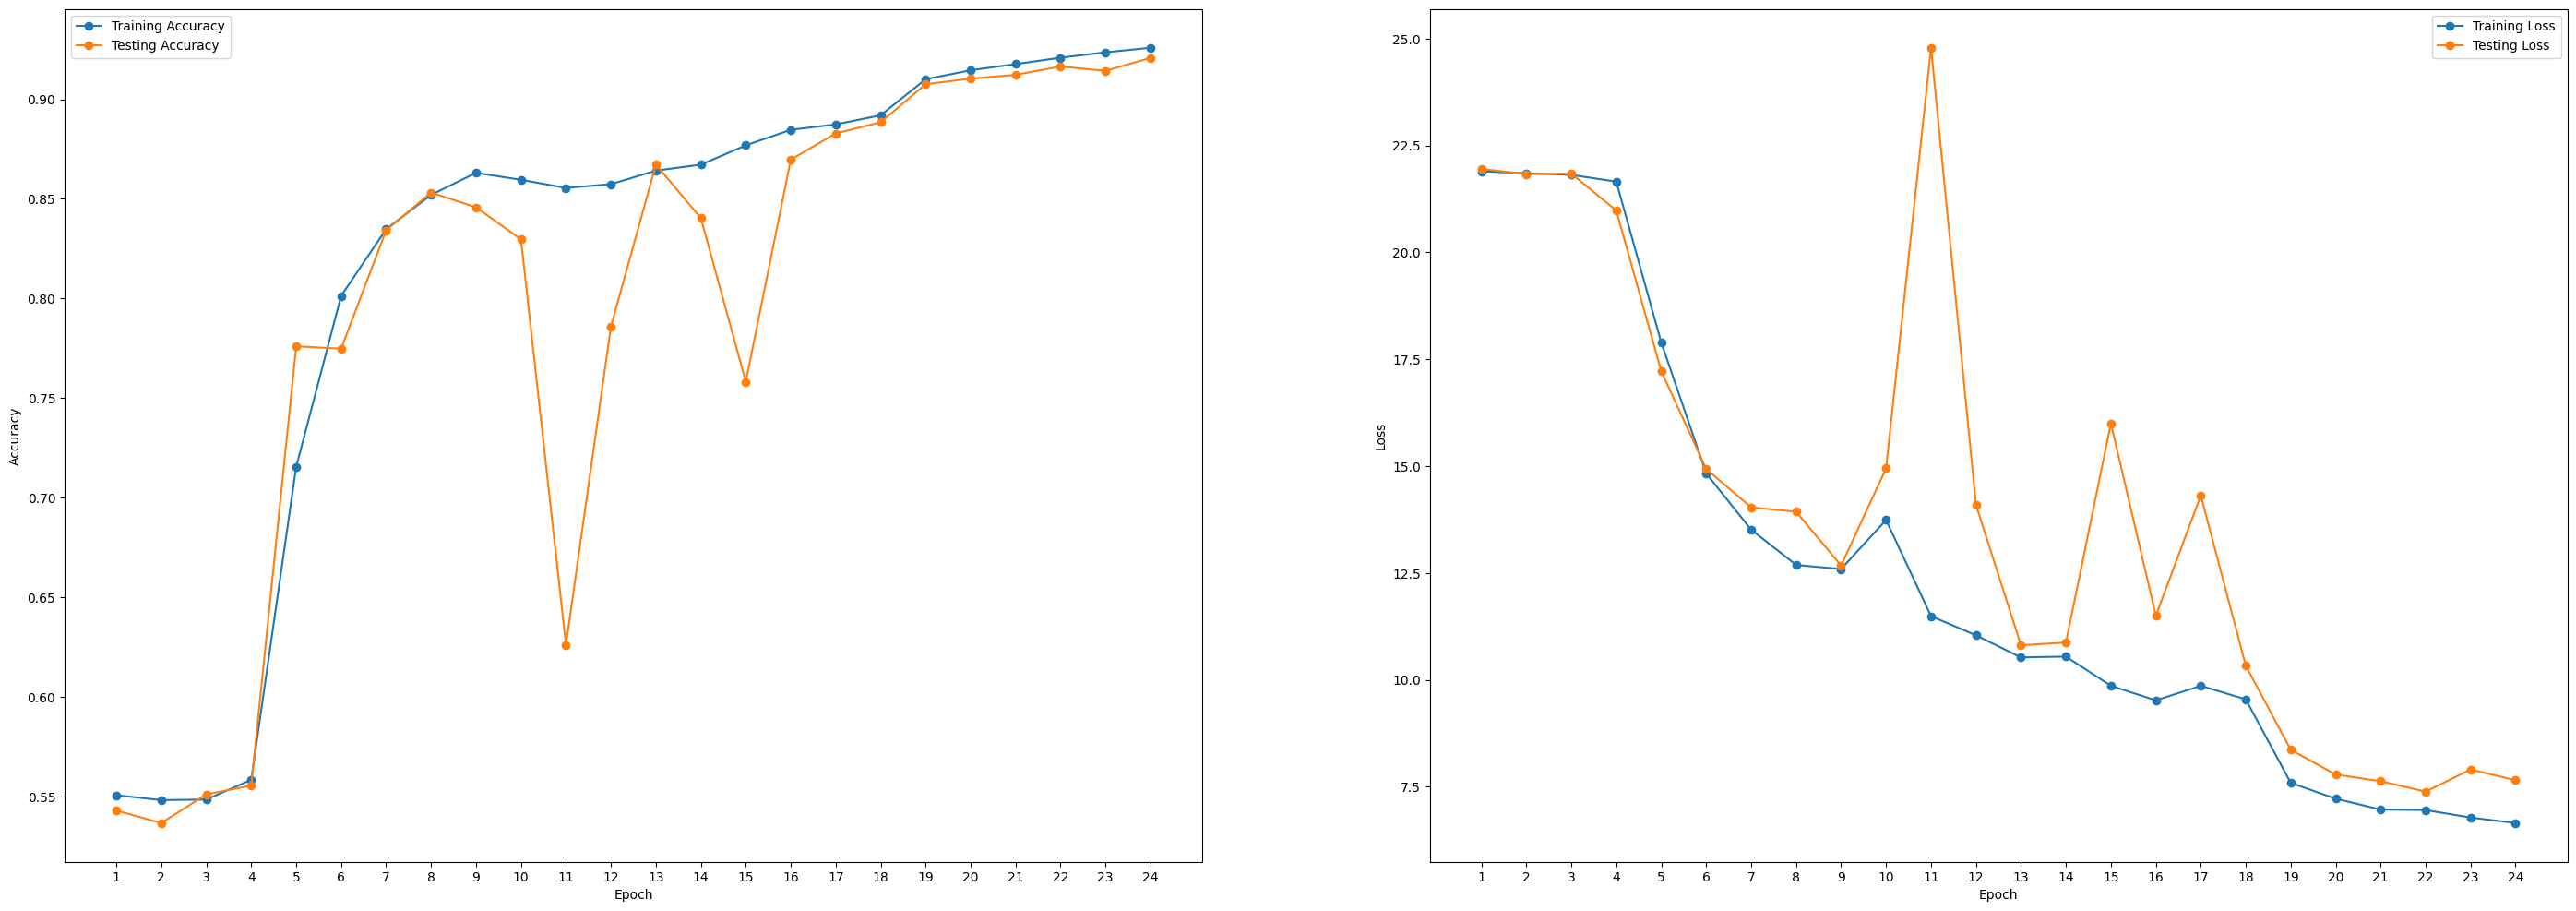

In [65]:
# ---- PLOTTING GRAPH OF LSS AND ACCURACY TO NUMBER OF EPOCH ----
fig, ((ax_one), (ax_two)) = plt.subplots(1, 2)


# ---- TRAINING AND TESTING ACCURACY TO EPOCH ----
epoch_accuracy = {"training_accuracy": [epochs_results.get(epoch).get('training_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "testing_accuracy": [epochs_results.get(epoch).get('testing_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('training_accuracy'), linestyle='-', marker='o')
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('testing_accuracy'), linestyle='-', marker='o')
ax_one.legend(['Training Accuracy', 'Testing Accuracy'])
ax_one.set_xticks(epoch_accuracy.get('epoch'), labels=epoch_accuracy.get('epoch'))
ax_one.set_xlabel("Epoch")
ax_one.set_ylabel("Accuracy")

# ---- TRAINING AND TESTING LOSS TO EPOCH ----
epoch_loss = {"training_loss": [epochs_results.get(epoch).get('training_loss') for epoch in range(1, max(epochs_results.keys())+1)], "testing_loss": [epochs_results.get(epoch).get('testing_loss') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('training_loss'), linestyle='-', marker='o')
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('testing_loss'), linestyle='-', marker='o')
ax_two.legend(['Training Loss', 'Testing Loss'])
ax_two.set_xticks(epoch_loss.get('epoch'), labels=epoch_loss.get('epoch'))
ax_two.set_xlabel("Epoch")
ax_two.set_ylabel("Loss")


fig.set_figheight(12)
fig.set_figwidth(35)
plt.show()
# plt.savefig('rnn_results.png')

In [63]:
# Saving Results to csv
results_df = pd.DataFrame.from_dict(epochs_results)
# results_df.to_csv('rnn_results.csv')
results_df = results_df.T
lr = list(results_df.learning_rate)
lr = [ele[0] for ele in lr]
results_df['learning_rate'] = lr

results_df.to_csv('rnn_results.csv')

# References
[https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

[https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/](https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/)

[https://www.geeksforgeeks.org/adjusting-learning-rate-of-a-neural-network-in-pytorch/#](https://www.geeksforgeeks.org/adjusting-learning-rate-of-a-neural-network-in-pytorch/#)

[https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_dimensions, nbr_layers_rnn, batch_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.nbr_layers_rnn = nbr_layers_rnn
        self.input_size = input_size
        self.batch_size = batch_size
    # this converts your sequence of words to a vector to pass through the NN
        self.word_sequence_to_embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_dimensions)
        """
        Your RNN (bi-directional=True creates a bi-directional RNN)
        - A bi-directional RNNs are well suited for jobs that call for knowledge of the context and connections among sequence elements
        """
        self.lstm = nn.LSTM(input_size=embedding_dimensions, hidden_size=hidden_size, num_layers=nbr_layers_rnn, batch_first=True,  dropout=0.2, bidirectional=False)
    # Fully connected layer
        self.fully_connected = nn.Linear(in_features=hidden_size, out_features=24)

    # Apply xavier normal weights
        torch.nn.init.xavier_normal_(self.fully_connected.weight)
    # Drop out
        self.drop = nn.Dropout(0.2)
    # fully_connected_two = nn.Linear
        self.fully_connected_two = nn.Linear(in_features=24, out_features=1)
    # Sigmoid activation
        self.activation = nn.Sigmoid()

    def forward(self, input_, hidden_tuple):
        batch_size = input_.size(0)
    # Create sequence embeddings
        sequence_embeddings = self.word_sequence_to_embedding(batch_size)
    # Compute output and hidden layers of RNN
        output, hidden_tuple = self.lstm(sequence_embeddings, hidden_tuple)


    # Compute fully connected layer
        fully_connected = self.fully_connected(output)

    # Add drop out
        drop = self.drop(fully_connected)

        fully_connected_two = self.fully_connected_two(drop)

    # Since embeddings are of the shape (Example, term, term_features), we must reduce to a matrix by taking the average
        fully_connected_reduced = torch.mean(fully_connected_two, dim=1)
    # Sigmoid Activation
        output = self.activation(fully_connected_reduced)
        return output, hidden_tuple

    def initHidden(self, batch_size):
    # Return a matrix of 1 row and k columns where k=hidden_size
        return (torch.zeros(self.nbr_layers_rnn, batch_size, self.hidden_size).to(device),
                torch.zeros(self.nbr_layers_rnn, batch_size, self.hidden_size).to(device))


In [ ]:
embedding_dimensions = 75
# this is the number of recurrent layers
nbr_layers_rnn = 4
n_hidden = 128
batch_size = 4
input_size = len(vocab_dict)
lstm_model = LSTM(input_size=input_size, hidden_size=n_hidden, embedding_dimensions=embedding_dimensions, nbr_layers_rnn=nbr_layers_rnn, batch_size=batch_size)
lstm_model.to(device)

LSTM(
  (word_sequence_to_embedding): Embedding(15000, 75)
  (lstm): LSTM(75, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fully_connected): Linear(in_features=128, out_features=24, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fully_connected_two): Linear(in_features=24, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [ ]:
# Create Loss function
lstm_criterion = nn.BCELoss()

# Create Optimizer
lstm_optimizer = optim.SGD(lstm_model.parameters(), lr=0.005, momentum=0.9)
# lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.005)
# Create Method to change learning rate by a factor of lr*0.1 after every epoch that doesn't have an effect on the loss function
# scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=0.01)

In [ ]:
epoch_iter = 2
def fit_lstm(model, trainloader, testloader, nbr_of_epochs, optimizer, criterion):
# Dictionary of epoch results
    epoch_results = {}
# Put model in training mode
    model.train()
# Iterate through epochs
    for epoch in range(nbr_of_epochs):
    # ---- MODEL TRAINING ----

    # Start timer for trainig of epoch
        start_time = time.perf_counter()
    # Initalize the batch number currently being worked on
        batch_nbr = 0
    # Create loss variable for epoch
        training_losses = 0.0
    # Total examples labeld correctly in epoch
        training_total_correct = 0.0
    # Total number of examples in epoch
        training_total_examples = 0.0
    # Create loss variable for epoch
        testing_losses = 0.0
    # Total examples labeld correctly in epoch
        testing_total_correct = 0.0
    # Total number of examples in epoch
        testing_total_examples = 0.0
    # Execute Forward, Backward, Optimization

    # Create loss variable for epoch
        testing_losses = 0.0
    # Total examples labeld correctly in epoch
        testing_total_correct = 0.0
    # Total number of examples in epoch
        testing_total_examples = 0.0


        for labels, inputs in trainloader:
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.float().to(device)
        # Detach the hidden layer so we don't compute gradient across hidden layers
        # Initialize hidden layer
            hidden_tuple = model.initHidden(batch_size)
            hidden_tuple = (hidden_tuple[0].detach(), hidden_tuple[1].detach())

        # Zero the parameter gradients
            optimizer.zero_grad()

        # ---- FORWARD, BACKWARD, OPTIMIZE ----
        # Get model training predictions
            outputs, hidden_tuple = model(inputs, hidden_tuple)
            outputs = torch.squeeze(outputs, 1)
        # Convert model training predictions to their respective classifications
            predicted_labels = get_labels(outputs)
        # Compute Loss of current batch
            loss = criterion(outputs, labels)

        # ---- LASSO Regularization ----
        # Initialize regularization loss penalty
            total_abs_weight = sum([torch.sum(torch.abs(beta)).item() for beta in model.parameters()])
            total_number_of_model_weights = sum([torch.numel(beta) for beta in model.parameters()])
            avg_abs_weight = total_abs_weight/total_number_of_model_weights
        # Add penaltiy to loss
            lambda_ = 0.01
            loss += lambda_ * avg_abs_weight

        # Compute total number of correctly classified examples
            nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
        # Grab batch size
            total_nbr_of_elements = labels.shape[0]
        # Compute number of correctly labeled examples and the total exampes
            training_total_correct += nbr_of_correct_predictions
            training_total_examples += total_nbr_of_elements

        # Backward pass
            loss.backward(retain_graph=True)
        # Update model params with gradient clippings
            nn.utils.clip_grad_norm_(model.parameters(), 2.5)
        # Initalize the next step of optimizer
            optimizer.step()
        # update training loss of epoch
            training_losses += float(loss.item())*total_nbr_of_elements
        #  update the current batch number of epoch
            batch_nbr += 1
    # End training time
        end_time = time.perf_counter()
    # Get total runntime of epoch
        epoch_runtime = timedelta(seconds=end_time-start_time).total_seconds()




    # Iterate through data
        for labels, inputs in testloader:
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.float().to(device)
        # Detach the hidden layer so we don't compute gradient across hidden layers
        # init hidden state
            hidden_test_tuple = model.initHidden()
            hidden_test_tuple[0].detach()
            hidden_test_tuple[1].detach()
            # hidden_test_tuple = (hidden_test_tuple[0].detach, hidden_test_tuple[1].detach)


        # ---- FORWARD, BACKWARD, OPTIMIZE ----
        # Get model training predictions
            outputs, hidden_test_tuple = model(inputs, hidden_test_tuple)
            outputs = torch.squeeze(outputs, 1)
        # Convert model training predictions to their respective classifications
            predicted_labels = get_labels(outputs)
        # Compute Loss of current batch
            loss = criterion(outputs, labels)

        # ---- LASSO Regularization ----
        # Initialize regularization loss penalty
            total_abs_weight = sum([torch.sum(torch.abs(beta)).item() for beta in model.parameters()])
            total_number_of_model_weights = sum([torch.numel(beta) for beta in model.parameters()])
            avg_abs_weight = total_abs_weight/total_number_of_model_weights
        # Add penaltiy to loss
            lambda_ = 0.01
            loss += lambda_ * avg_abs_weight

        # Compute total number of correctly classified examples
            nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
        # Grab batch size
            total_nbr_of_elements = labels.shape[0]
        # Compute number of correctly labeled examples and the total exampes
            testing_total_correct += nbr_of_correct_predictions
            testing_total_examples += total_nbr_of_elements

        # del labels, inputs from memory
            del labels
            del outputs

    # ---- COMPUTING ACCURACY/LOSS ----
    # Compute training accuracy/loss of epoch
        total_training_epoch_loss = round(training_losses/len(trainloader), 4)
        training_accuracy = round(training_total_correct/training_total_examples, 4)
    # Compute training accuracy/loss of epoch
        total_testing_epoch_loss = round(testing_losses/len(testloader), 4)
        testing_accuracy = round(testing_total_correct/testing_total_examples, 4)

    # ---- LEARNING RATE ----
    # Current learning rate
        current_lr = scheduler.get_last_lr()
    # Adjust learning rate
        scheduler.step()

    # ---- RESULTS ----
    # print results of epoch
        # print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_training_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
        print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s <-> Learning Rate: {current_lr} <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_training_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
    # Update results of epochs
        # result_dict = { "runtime": epoch_runtime,
        #                "training_loss": total_training_epoch_loss, 'training_accuracy': training_accuracy,
        #                "testing_loss": total_testing_epoch_loss, 'testing_accuracy': testing_accuracy,}
        result_dict = { "runtime": epoch_runtime, #"learning_rate": current_lr,
                       "training_loss": total_training_epoch_loss, 'training_accuracy': training_accuracy,
                       "testing_loss": total_testing_epoch_loss, 'testing_accuracy': testing_accuracy,}
        epoch_results.update({epoch+1: result_dict})
    return epoch_results

In [ ]:
epochs_results = fit_lstm(model=lstm_model, trainloader=train_loader, testloader=test_loader, nbr_of_epochs=epoch_iter, optimizer=lstm_optimizer, criterion=lstm_criterion)

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not int

In [ ]:
# ---- PLOTTING GRAPH OF LSS AND ACCURACY TO NUMBER OF EPOCH ----
fig, ((ax_one), (ax_two)) = plt.subplots(1, 2)


# ---- TRAINING AND TESTING ACCURACY TO EPOCH ----
epoch_accuracy = {"training_accuracy": [epochs_results.get(epoch).get('training_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "testing_accuracy": [epochs_results.get(epoch).get('testing_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('training_accuracy'), linestyle='-', marker='o')
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('testing_accuracy'), linestyle='-', marker='o')
ax_one.legend(['Training Accuracy', 'Testing Accuracy'])
ax_one.set_xticks(epoch_accuracy.get('epoch'), labels=epoch_accuracy.get('epoch'))
ax_one.set_xlabel("Epoch")
ax_one.set_ylabel("Accuracy")

# ---- TRAINING AND TESTING LOSS TO EPOCH ----
epoch_loss = {"training_loss": [epochs_results.get(epoch).get('training_loss') for epoch in range(1, max(epochs_results.keys())+1)], "testing_loss": [epochs_results.get(epoch).get('testing_loss') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('training_loss'), linestyle='-', marker='o')
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('testing_loss'), linestyle='-', marker='o')
ax_two.legend(['Training Loss', 'Testing Loss'])
ax_two.set_xticks(epoch_loss.get('epoch'), labels=epoch_loss.get('epoch'))
ax_two.set_xlabel("Epoch")
ax_two.set_ylabel("Loss")



fig.set_figheight(12)
fig.set_figwidth(25)
plt.show()

In [ ]:
import torch.nn as nn


class LSTM_Model(nn.Module):
    def __init__(self, dictionary_size, embedding_size, hidden_size, number_layers, lstm_drop=0.5, fully_connected_drop=0.5):
        super(LSTM_Model, self).__init__()
        self.number_layers = number_layers
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Embedding(dictionary_size,embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_size, number_layers, dropout=lstm_drop, batch_first=True)
        self.fully_connected_dropout = nn.Dropout(fully_connected_drop)
        #the output dimension should be 1
        self.fully_connected_layer = nn.Linear(hidden_size, 1)
        self.sigmoid_function = nn.Sigmoid()

    def forward(self, x, hidden_state):
        batch_size = x.size(0)
        # print(f"batch size {batch_size}")
        x = self.embedding_layer(x)
        x, hidden_state = self.lstm_layer(x, hidden_state)
        # print(f"lstm out shape: {x.shape}")
        x = x.contiguous().view(-1, self.hidden_size)
        # print(f"lstm out shape: {x.shape}")
        x = self.fully_connected_dropout(x)
        x = self.fully_connected_layer(x)
        # print(f"fully connected out shape: {x.shape}")
        x = self.sigmoid_function(x)
        # print(f"sigmoid out 1: {x.shape}")
        x = x.view(batch_size, -1)
        # print(f"sigmoid: {x.shape}")
        x = x[:, -1]
        # print(f"sigmoid out3: {x.shape}")
        return x, hidden_state

    def initialize_hidden_state(self, batch_size):
        weight = next(self.parameters()).data
        if device == "cuda":
            hidden_state = (weight.new(self.number_layers, batch_size, self.hidden_size).zero_().to(device),
                      weight.new(self.number_layers, batch_size, self.hidden_size).zero_().to(device))
        else:
            hidden_state = (weight.new(self.number_layers, batch_size, self.hidden_size).zero_(),
                      weight.new(self.number_layers, batch_size, self.hidden_size).zero_())

        return hidden_state



In [ ]:
dictionary_size = input_size
number_layers = 1
embedding_size = 100
hidden_size = 100



In [ ]:

model = LSTM_Model(dictionary_size=dictionary_size, embedding_size=embedding_size, hidden_size=hidden_size, number_layers=number_layers)
model.to(device)

print(model)

LSTM_Model(
  (embedding_layer): Embedding(15000, 100)
  (lstm_layer): LSTM(100, 100, batch_first=True, dropout=0.5)
  (fully_connected_dropout): Dropout(p=0.5, inplace=False)
  (fully_connected_layer): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid_function): Sigmoid()
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
|loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
number_epochs = 5
gradient_clip = 10

for epoch in range(number_epochs):
    train_loss_total = 0.0
    val_loss_total = 0.0
    train_correct = 0
    val_correct = 0
    train_samples = 0
    val_samples = 0

    model.train()
    for inputs, labels in train_loader:
        batch_size = inputs.size(0)
        if device == "cuda":
            inputs, labels = inputs.cuda(), labels.cuda()

        hidden = model.initialize_hidden_state(batch_size)
        hidden = (hidden[0].detach(), hidden[1].detach())
        # hidden = tuple([h.data for h in hidden])

        model.zero_grad()
        outputs, hidden = model(inputs, hidden)
        loss = loss_function(outputs.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()

        train_loss_total += loss.item() * batch_size
        train_samples += batch_size
        prediction_train = torch.round(outputs.squeeze())
        correct_train = prediction_train.eq(labels.float().view_as(prediction_train))
        correct_train_np = correct_train.cpu().numpy() if device == "cuda" else correct_train.numpy()
        train_correct += np.sum(correct_train_np)

    avg_train_loss = train_loss_total / train_samples
    train_accuracy = train_correct / train_samples

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            batch_size = inputs.size(0)
            if device == "cuda":
                inputs, labels = inputs.to(device), labels.to(device)

            val_hidden = model.initialize_hidden_state(batch_size)
            val_hidden = tuple([h.data for h in val_hidden])

            outputs, val_hidden = model(inputs, val_hidden)
            loss = loss_function(outputs.squeeze(), labels.float())

            val_loss_total += loss.item() * batch_size
            val_samples += batch_size
            pred_val = torch.round(outputs.squeeze())
            correct_val = pred_val.eq(labels.float().view_as(pred_val))
            correct_val_np = correct_val.cpu().numpy() if device == "cuda" else correct_val.numpy()
            val_correct += np.sum(correct_val_np)

    avg_val_loss = val_loss_total / val_samples
    val_accuracy = val_correct / val_samples
    scheduler.step(avg_val_loss)

    print(f"finished training epoch: {epoch + 1}/{number_epochs}",
          f"training loss: {avg_train_loss:.5f} ------------------ training accuracy: {train_accuracy:.5f}",
          f"test loss: {avg_val_loss:.5f} ------------------ test accuracy: {val_accuracy:.5f}",)


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
testing_losses = []
number_correct_outputs = 0
hidden_state = model.initialize_hidden_state(batch_size)

model.eval()

for inputs, labels in test_loader:
    if device == "cuda":
        inputs, labels = inputs.cuda(), labels.cuda()
    hidden_state = model.initialize_hidden_state(inputs.size(0))
    output, hidden_state = model(inputs, hidden_state)

    loss_of_test_data = loss_function(output.squeeze(), labels.float())
    testing_losses.append(loss_of_test_data.item())
    prediction = torch.round(output.squeeze())
    correct_tensor = prediction.eq(labels.float().view_as(prediction))
    correct = np.squeeze(correct_tensor.numpy()) if not device == "cuda" else np.squeeze(correct_tensor.cpu().numpy())
    number_correct_outputs += np.sum(correct)

test_accuracy = number_correct_outputs/len(test_loader.dataset)

print("test data loss: {:.5f}".format(np.mean(testing_losses)))
print("test data accuracy: {:.5f}%".format(test_accuracy*100))

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors